In [4253]:
import numpy as np

# 3-state qudit

In [4254]:
d = 3

### Generate "unkown" state you want to learn

In [4255]:
# From ChatGPT
def random_complex_vector(n):
    # Generate random real and imaginary parts
    real_part = np.random.uniform(low=-1, high=1, size=n)
    imag_part = np.random.uniform(low=-1, high=1, size=n)
    
    # Combine them to form a complex vector
    vector = real_part + 1j * imag_part
    
    # Normalize the vector to have norm = 1
    norm = np.linalg.norm(vector)
    normalized_vector = vector / norm
    
    return normalized_vector

In [4256]:
psi = random_complex_vector(d).reshape(-1, 1)
unkown_dm = psi @ psi.conj().T

### Define measurement bases 

In [4257]:
# TODO: figure out if these are the right bases
measurement_strings = ["0", "1", "2", "+", "+-+", "-+-" "_i_", "i_i", "_-i_", "-i_-i"]

zero = np.array([1, 0, 0]).reshape(-1, 1)
one = np.array([0, 1, 0]).reshape(-1, 1)
two = np.array([0, 0, 1]).reshape(-1, 1)

# -1 phase
plus = 1/np.sqrt(3) * np.array([1, 1, 1]).reshape(-1, 1)
minus = 1/np.sqrt(3) * np.array([1, -1, 1]).reshape(-1, 1)
minus_minus = 1/np.sqrt(3) * np.array([-1, 1, -1]).reshape(-1, 1)

# i phase
_i_ = 1/np.sqrt(3) * np.array([1, 1j, 1]).reshape(-1, 1)
i_i = 1/np.sqrt(3) * np.array([1j, 1, 1j]).reshape(-1, 1)

# -i phase
_minusi_ = 1/np.sqrt(3) * np.array([1, -1j, 1]).reshape(-1, 1)
minusi_minusi = 1/np.sqrt(3) * np.array([-1j, 1, -1j]).reshape(-1, 1)

basis_states = [zero, one, two, plus, minus, minus_minus, _i_, i_i, _minusi_, minusi_minusi]

### Create measurement projectors

In [4258]:
measurement_operators = [state_vector @ state_vector.conj().T for state_vector in basis_states]
measurement_op_dict = dict(zip(measurement_strings, measurement_operators))
#measurement_op_dict

### Compute probabilities to use as the data to fit to
Experimentally, you would compute these from measurement counts

In [4259]:
def get_probabilities(dm):
    return [np.trace(dm @ measurement_op).real for measurement_op in measurement_operators]

probabilities = get_probabilities(unkown_dm)
prob_dict = dict(zip(measurement_strings, probabilities))

### Create tunable state
Parameterization from Kwiat group lecture: https://www.youtube.com/watch?v=-T_GiHE4VGg

In [4260]:
def get_parameterized_dm(t1, t2, t3, t4, t5, t6, t7, t8, t9):
    T = np.array([[t1, 0, 0],
                  [t4 + 1j*t5, t2, 0],
                  [t8 + 1j*t9, t6 + 1j*t7, t3]])
    
    parameterized_rho = (T.conj().T @ T) / np.trace(T.conj().T @ T)
    
    return parameterized_rho

In [4261]:
dm_parameters = np.random.uniform(low=-1, high=1, size=9)

In [4262]:
parameterized_dm = get_parameterized_dm(*dm_parameters)

### Test that DM is valid

In [4263]:
# Check that trace is close to one
assert np.allclose(1, np.trace(parameterized_dm))

# Check Hermitian
assert np.allclose(parameterized_dm, parameterized_dm.conj().T)

# Check positive-semi definite <--> eigenvalues >= 0
assert np.all(np.linalg.eigvalsh(parameterized_dm) >= 0)

### Optimize with SciPy

In [4264]:
def get_probabilites_from_parameters(t1, t2, t3, t4, t5, t6, t7, t8, t9):
    parameterized_dm = get_parameterized_dm(t1, t2, t3, t4, t5, t6, t7, t8, t9)
    probabilities = get_probabilities(parameterized_dm)
    return probabilities

In [4265]:
from scipy.special import kl_div

def kl_divergence(true_probs, t1, t2, t3, t4, t5, t6, t7, t8, t9):
    probs = get_probabilites_from_parameters(t1, t2, t3, t4, t5, t6, t7, t8, t9)
    return sum(kl_div(true_probs, probs))

kl_divergence_from_parameters = lambda params : kl_divergence(probabilities, *params)

In [4266]:
from scipy.optimize import minimize

# TODO: try different methods
#optimization_result = minimize(kl_divergence_from_parameters, dm_parameters, method="L-BFGS-B")
optimization_result = minimize(kl_divergence_from_parameters, dm_parameters, method="CG")



In [4267]:
found_params = optimization_result.x

found_dm = get_parameterized_dm(*found_params)

In [4268]:
dm_fidelity = lambda d1, d2 : np.trace(d1.T.conj() @ d2).real

dm_fidelity(unkown_dm, found_dm)

0.9980870537053015

### Plot Density Matrices

In [4269]:
import matplotlib as mplt
import matplotlib.pyplot as plt
%matplotlib inline

In [4270]:
def bar_plot_3d(top, title=""):
    # set up the figure and axes
    fig = plt.figure(figsize=(8, 3))
    ax = fig.add_subplot(121, projection='3d')

    x_dim = y_dim = len(top)
    
    # fake data
    _x = np.arange(x_dim)
    _y = np.arange(y_dim)
    _xx, _yy = np.meshgrid(_x, _y)
    x, y = _xx.ravel(), _yy.ravel()

    # top = x + y

    bottom = np.zeros_like(top)
    width = depth = 0.5

    ax.bar3d(x, y, bottom.flatten(), width, depth, top.flatten(), shade=True)
    ax.set_title(title)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xlabel("row")
    ax.set_ylabel("column")


    plt.show()

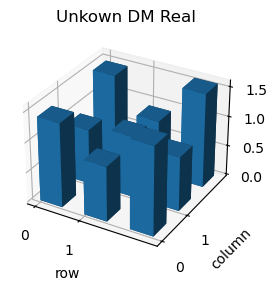

[[1.4047453  0.91839235 1.48039609]
 [0.91839235 1.02120338 0.90742315]
 [1.48039609 0.90742315 1.57405132]]


In [4271]:
bar_plot_3d(unkown_dm.real + 1, title="Unkown DM Real")
print(unkown_dm.real + 1)

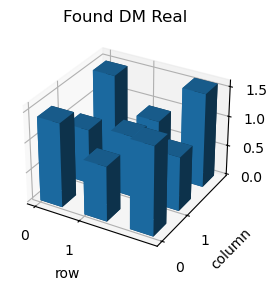

[[1.40474412 0.91980773 1.48040005]
 [0.91980773 1.02121735 0.90606869]
 [1.48040005 0.90606869 1.57403852]]


In [4272]:
bar_plot_3d(found_dm.real + 1, title="Found DM Real")
print(found_dm.real + 1)

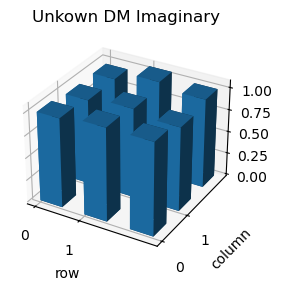

[[1.         1.04384244 1.03954957]
 [0.95615756 1.         0.93998872]
 [0.96045043 1.06001128 1.        ]]


In [4273]:
bar_plot_3d(unkown_dm.imag + 1, title="Unkown DM Imaginary")
print(unkown_dm.imag + 1)

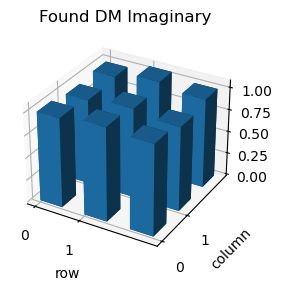

[[1.         1.04590622 1.01604001]
 [0.95409378 1.         0.94207474]
 [0.98395999 1.05792526 1.        ]]


In [4274]:
bar_plot_3d(found_dm.imag + 1, title="Found DM Imaginary")
print(found_dm.imag + 1)

## Reconstruct state vector from the density matrix 

In [4275]:
# TEST: reconstruct statevector from psi
def density_matrix_to_state_vector(rho):
    """Extracts a state vector from a pure-state density matrix."""
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(rho)

    # Find the eigenvector corresponding to eigenvalue ~1
    idx = np.argmax(eigenvalues)  # The largest eigenvalue (should be ~1 for a pure state)
    print(eigenvalues)
    
    # Extract the corresponding eigenvector
    state_vector = eigenvectors[:, idx]

    # Normalize the state vector
    state_vector = state_vector / np.linalg.norm(state_vector)

    return state_vector

#### original psi

In [4276]:
print("original psi", psi)

prob_0 = np.abs(psi[0])**2
prob_1 = np.abs(psi[1])**2
print("prob_0", prob_0)
print("prob_1", prob_1)

original psi [[ 0.55919096+0.3033987j ]
 [-0.07988362-0.12174558j]
 [ 0.69335565+0.30546565j]]
prob_0 [0.4047453]
prob_1 [0.02120338]


#### original psi from density matrix, testing that it matches psi

In [4277]:
original_psi_from_dm = density_matrix_to_state_vector(unkown_dm)
print("original_psi_from_dm", original_psi_from_dm)

prob_0 = np.abs(original_psi_from_dm[0])**2
prob_1 = np.abs(original_psi_from_dm[1])**2
print("prob_0", prob_0)
print("prob_1", prob_1)

[-9.97763563e-17  1.26730871e-16  1.00000000e+00]
original_psi_from_dm [ 0.63619596+0.j         -0.12827439-0.06891342j  0.75510711-0.06216571j]
prob_0 0.4047452976163854
prob_1 0.021203379040330282


#### statevector from reconstructed dm

In [4278]:
found_psi_from_dm = density_matrix_to_state_vector(found_dm)
print("found_psi_from_dm", found_psi_from_dm)
prob_0 = np.abs(found_psi_from_dm[0])**2
prob_1 = np.abs(found_psi_from_dm[1])**2
print("prob_0", prob_0)
print("prob_1", prob_1)

[1.32587813e-07 1.34948678e-03 9.98650381e-01]
found_psi_from_dm [-0.63599329+0.j          0.12646308+0.0723263j  -0.75739659+0.02527731j]
prob_0 0.40448746414891457
prob_1 0.02122400571520113


### State vector fidelity

In [4279]:
def statevector_fidelity(psi, phi):
    """Computes the fidelity between two state vectors."""
    psi = np.array(psi, dtype=complex)
    phi = np.array(phi, dtype=complex)
    
    # Normalize the state vectors
    psi /= np.linalg.norm(psi)
    phi /= np.linalg.norm(phi)
    
    # Compute fidelity
    fidelity = np.abs(np.vdot(psi, phi)) ** 2
    return fidelity

In [4280]:
statevector_fidelity(psi, found_psi_from_dm)

0.9994351635442532